In [5]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Rescaling, Conv2D, \
                                    Dropout, MaxPooling2D,\
                                    Flatten, Dense, ReLU, Lambda

In [2]:
width = 200
height = 150
num_sig = 55

In [8]:
def make_pairs(genuine, forged):

    #create (genuine, genuine) pairs
    gen_gen_pairs = []
    for t in itertools.combinations(genuine, 2):
        gen_gen_pairs.append([t[0], t[1]])

    #create (genuine, forged) pairs
    gen_forg_pairs_temp = []
    for t in itertools.product(genuine, forged):
        gen_forg_pairs_temp.append([t[0], t[1]])

    gen_gen_pairs = np.array(gen_gen_pairs)
    gen_forg_pairs_temp = np.array(gen_forg_pairs_temp)

    # pick the same number of (genuine, forged) pairs as the (genuine, genuine)
    # ones in order to balance the data
    gen_forg_indices = random.sample(range(1, gen_forg_pairs_temp.shape[0]), gen_gen_pairs.shape[0])

    gen_forg_pairs = []
    for ind in gen_forg_indices:
        gen_forg_pairs.append(gen_forg_pairs_temp[ind])

    gen_forg_pairs = np.array(gen_forg_pairs)

    return gen_gen_pairs, gen_forg_pairs


def prepare_data(genuine, forged, X, y):

    gen_gen_pairs, gen_forg_pairs = make_pairs(genuine, forged)
    all_pairs = np.empty((552, 2, width, height))
    all_pairs = np.concatenate((gen_gen_pairs, gen_forg_pairs), axis = 0)
    print(f"All pairs shape: {all_pairs.shape}")
    labels = np.concatenate((np.ones(gen_gen_pairs.shape[0]), np.zeros(gen_forg_pairs.shape[0])), axis = 0)
    print(f"Labels shape: {labels.shape}")
    
    combined = list(zip(all_pairs, labels))
    random.shuffle(combined)
    shuffled_pairs, shuffled_labels = zip(*combined)
    
    X[:] = shuffled_pairs
    y[:] = shuffled_labels

In [11]:
parent_path = "C:/Users/User/Desktop/ML Projects/archive/signatures/"

In [12]:
X = np.empty((num_sig * 2 * 276, 2, height, width))
y = np.empty((num_sig * 2 * 276))

m = 0
for ind in range(1, num_sig+1):

    print(f"Iteration number {m+1}")
    genuine = np.empty((24, height, width))
    forged = np.empty((24, height, width))

    path = parent_path + "signatures_" + str(ind)

    i = 0
    j = 0
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        if os.path.isfile(image_path):
          img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
          img = 255 - img
          img = cv2.resize(img, (width, height))
          if(image.split("_")[0] == "original"):
            genuine[i] = img
            i += 1
          elif(image.split("_")[0] == "forgeries"):
            forged[j] = img
            j += 1

    #prepare_data(genuine, forged, X_train, y_train, m)
    prepare_data(genuine, forged, X[m*552:(m+1)*552], y[m*552:(m+1)*552])
    m += 1


print(f"X shape : {X.shape}")
print(f"y shape : {y.shape}")

Iteration number 1
All pairs shape: (552, 2, 150, 200)
Labels shape: (552,)
Iteration number 2
All pairs shape: (552, 2, 150, 200)
Labels shape: (552,)
Iteration number 3
All pairs shape: (552, 2, 150, 200)
Labels shape: (552,)
Iteration number 4
All pairs shape: (552, 2, 150, 200)
Labels shape: (552,)
Iteration number 5
All pairs shape: (552, 2, 150, 200)
Labels shape: (552,)
Iteration number 6
All pairs shape: (552, 2, 150, 200)
Labels shape: (552,)
Iteration number 7
All pairs shape: (552, 2, 150, 200)
Labels shape: (552,)
Iteration number 8
All pairs shape: (552, 2, 150, 200)
Labels shape: (552,)
Iteration number 9
All pairs shape: (552, 2, 150, 200)
Labels shape: (552,)
Iteration number 10
All pairs shape: (552, 2, 150, 200)
Labels shape: (552,)
Iteration number 11
All pairs shape: (552, 2, 150, 200)
Labels shape: (552,)
Iteration number 12
All pairs shape: (552, 2, 150, 200)
Labels shape: (552,)
Iteration number 13
All pairs shape: (552, 2, 150, 200)
Labels shape: (552,)
Iteratio

In [13]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]
        
        n = random.randint(0, pairs.shape[0])
        print(f"Index to show: {n}")
        ax.imshow(np.concatenate([pairs[n][0], pairs[n][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[n], predictions[n][0]))
        else:
            ax.set_title("Label: {}".format(labels[n]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

Index to show: 23413
Index to show: 11138
Index to show: 13032
Index to show: 24570


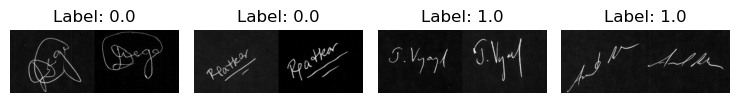

In [14]:
visualize(X[:-1], y[:-1], to_show = 4, num_col = 4)

In [15]:
np.save("X.npy", X)  # Saves in the current directory
np.save("y.npy", y)  # Saves in the current directory

In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)
    
!nvidia-smi

Mon Feb  3 22:07:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2070 ...  WDDM  |   00000000:06:00.0  On |                  N/A |
| 52%   37C    P0             45W /  215W |    1839MiB /   8192MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
width = 200
height = 150
channels = 1
input_shape = (height, width, channels)

In [8]:
def load_data():
    X = np.load("C:/Users/User/Desktop/ML Projects/X.npy")
    print(X.shape)
    y = np.load("C:/Users/User/Desktop/ML Projects/y.npy")
    print(y.shape)

    X_t, X_test, y_t, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    print(X_t.shape)
    print(y_t.shape)
    print(X_test.shape)
    print(y_test.shape)

    del X
    del y

    X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size = 0.2, random_state = 42)
    print(X_train.shape)
    print(y_train.shape)
    print(X_val.shape)
    print(y_val.shape)

    del X_t
    del y_t

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_data()

(30360, 2, 150, 200)
(30360,)
(21252, 2, 150, 200)
(21252,)
(9108, 2, 150, 200)
(9108,)
(17001, 2, 150, 200)
(17001,)
(4251, 2, 150, 200)
(4251,)


In [9]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]
        
        n = random.randint(0, pairs.shape[0])
        print(f"Index to show: {n}")
        ax.imshow(np.concatenate([pairs[n][0], pairs[n][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[n], predictions[n][0]))
        else:
            ax.set_title("Label: {}".format(labels[n]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

Index to show: 16173
Index to show: 12348
Index to show: 881
Index to show: 4182


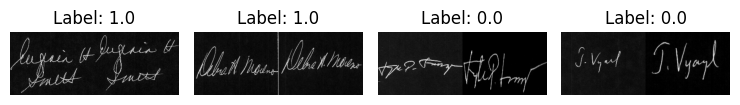

In [10]:
visualize(X_train[:-1], y_train[:-1], to_show = 4, num_col = 4)

Index to show: 2582
Index to show: 2049
Index to show: 2234
Index to show: 3189


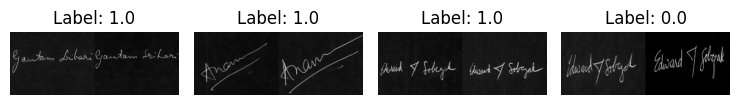

In [11]:
visualize(X_val[:-1], y_val[:-1], to_show = 4, num_col = 4)

Index to show: 1658
Index to show: 936
Index to show: 2100
Index to show: 1607


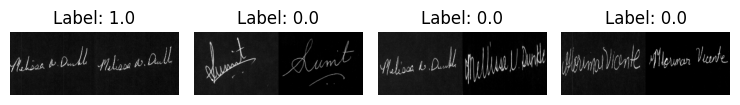

In [12]:
visualize(X_test[:-1], y_test[:-1], to_show = 4, num_col = 4)

In [13]:
def siamese_network(input_shape):
    input = Input(input_shape)

    x = Rescaling(1/255)(input)

    x = Conv2D(64, (11, 11), activation = "relu")(input)
    x = Lambda(tf.nn.local_response_normalization)(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)

    x = Conv2D(128, (7, 7), activation = "relu")(x)
    x = Lambda(tf.nn.local_response_normalization)(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (5, 5), activation = "relu")(x)

    x = Conv2D(512, (3, 3), activation = "relu")(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)

    x = Dense(1024, activation = "relu")(x)
    x = Dropout(0.5)(x)

    x = Flatten()(x)

    x = Dense(128, activation = "relu")(x)

    model = Model(input, x)

    return model

def euclidean_distance(vecs):
    (imgA, imgB) = vecs
    sum_square = K.sum(K.square(imgA - imgB), axis = 1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [14]:
imageA = Input(input_shape)
imageB = Input(input_shape)

siamese = siamese_network(input_shape)

modelA = siamese(imageA)
modelB = siamese(imageB)

distance = Lambda(euclidean_distance, output_shape=(1,))([modelA, modelB])

output = Dense(1, activation = "sigmoid")(distance)

model = Model(inputs = [imageA, imageB], outputs = output)

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 200,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 150, 200,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │ 35,309,184 │ input_layer[0][0… │
│ (Functional)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ lambda_2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,309,186 (134.69 MB)

 Trainable params: 35,309,186 (134.69 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
batch_size = 64
epochs = 20
early_stopping = EarlyStopping(monitor = "val_loss", patience = 5, verbose = 1)

history = model.fit([X_train[:, 0, :, :], X_train[:, 1, :, :]], y_train,
                    validation_data = ([X_val[:, 0, :, :], X_val[:, 1, :, :]], y_val),
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = [early_stopping],
                    verbose = 1)

Epoch 1/20
131/266 ━━━━━━━━━━━━━━━━━━━━ 27:04 12s/step - accuracy: 0.7931 - loss: 0.4132

KeyboardInterrupt: 